In [ ]:
# MagnaTagATune Dataset:
# https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset
# Citation: Edith Law, Kris West, Michael Mandel, Mert Bay and J. Stephen Downie (2009). Evaluation of algorithms using games: the case of music annotation. In  Proceedings of the 10th International Conference on Music Information Retrieval (ISMIR)

# GTZAN Dataset:
# https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

#https://musicinformationretrieval.com/spectral_features.html

#https://ofai.at/papers/oefai-tr-2006-13.pdf
#tonnetz



# These are default standard-library things, so we don't have to install them.
import sys
import os
import glob
import random

import librosa
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_blobs as sklearn_datasets_make_blobs # TODO: Eliminate this dependency. We only use it for one thing.
import k_means_constrained

if not os.path.isdir("Datasets"):
  raise IOError("No Datasets folder exists. This probably means the datasets are not downloaded. Please refer to the readme.")

print(f"Working directory: {os.getcwd()}")

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  torch.set_default_device(device)
  print("Torch is using CUDA.")
else:
  print("Torch is using the CPU.")

Working directory: C:\MusicClassifier
Torch is using CUDA.


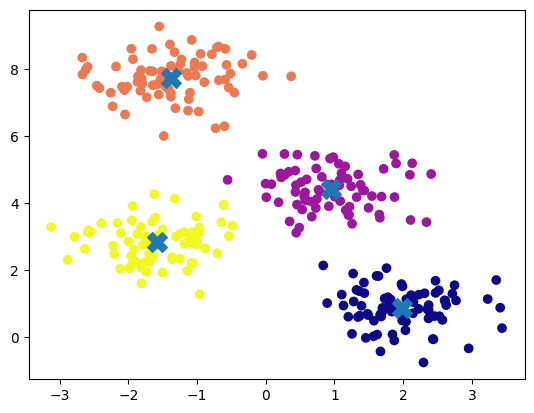

In [5]:
# ##### K-Means ######

# Here's our implementation.
# It's pretty basic, and doesn't do anything to optimize output results for size.
# As such, the clusters usually end up with weird shapes.
# The k_means_constrained algorithm does a better job.

# 
# # Implementation taken from here.
# # https://www.geeksforgeeks.org/pytorch-for-unsupervised-clustering/
# 
# 
# # data: A [data_count * feature_count] torch tensor.
# # returns a tuple (centroids, labels).
# #   centroids: [centroid_count, feature_count] torch tensor
# #   labels: [data_count] torch tensor. Contains the index of each centroid that the given data uses.
# def k_means_cluster(data, centroid_count, iteration_count):
#   feature_count = data.size(dim=1)
# 
#   # TODO: Figure out a better way to initialize the centroids
#   # centroids = torch.rand((centroid_count, feature_count))
#   centroids = data[torch.randperm(data.size(0))[:4]]
# 
#   labels = None
#   for iteration_index in range(iteration_count):
#     distances = torch.cdist(data, centroids)
#     # distances is [data_count, centroid_count]
#     # The distance from each data point to each centroid.
# 
#     # Find the nearest centroid to each data point
#     _, labels = torch.min(distances, dim=1) # labels is a [data_count] tensor
# 
#     for i in range(centroid_count):
#       labels_that_use_this_centroid = labels == i
#       # True for all the indices of data that have this as the nearest centroid, false otherwise
#       if torch.sum(labels_that_use_this_centroid == i) > 0:
# 
#         # This is a goofy overload.
#         # Get all data that has centroid i as the closest centroid.
#         data_that_uses_this_centroid = data[labels_that_use_this_centroid]
# 
#         centroids[i] = torch.mean(data_that_uses_this_centroid, dim=0)
# 
#     if iteration_index == iteration_count - 1:
#       return (centroids, labels)
# 
# 
# # TODO: Make sure this is actually working. The output looks a little weird, but that may have to do with the initial centroid values.
# def test_k_means_cluster():
#   centroid_count = 4
#   data, _ = sklearn_datasets_make_blobs(n_samples=300, centers=centroid_count, cluster_std=0.60, random_state=0)
# 
#   tensor_data = torch.tensor(data, dtype=torch.float32)
#   centroids_gpu, labels_gpu = k_means_cluster(tensor_data, centroid_count, 10000)
# 
#   # We have to transfer it to numpy to be able to use plt on it.
#   centroids = centroids_gpu.cpu().numpy()
#   labels = labels_gpu.cpu().numpy()
# 
#   plt.scatter(data[:, 0], data[:, 1], c=labels, cmap="plasma")
#   plt.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=200)
#   plt.show()
# test_k_means_cluster()

def test_k_means_cluster():
  centroid_count = 4

  data, _ = sklearn_datasets_make_blobs(n_samples=300, centers=centroid_count, cluster_std=0.60, random_state=0)

  clf = k_means_constrained.KMeansConstrained(
      n_clusters=centroid_count,
      size_min=50,
      size_max=100,
      random_state=0
  )
  labels = clf.fit_predict(data)
  centroids = clf.cluster_centers_

  plt.scatter(data[:, 0], data[:, 1], c=labels, cmap="plasma")
  plt.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=200)
test_k_means_cluster()

In [ ]:
def plot_spectral_flatness(): # Test spectral flatness graph
  (file_data, file_sample_rate) = librosa.load("Datasets/MagnaTagATune/0/american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-0-29.mp3")
  print(len(file_data))

  # matplotlib test data
  S = librosa.feature.melspectrogram(y=file_data, sr=file_sample_rate, n_mels=128, fmax=8000)

  fig, ax = plt.subplots()
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=file_sample_rate, fmax=8000, ax=ax)
  fig.colorbar(img, ax=ax, format='%+2.0f dB')
  ax.set(title='Mel-frequency spectrogram')
# plot_spectral_flatness()


# Because of dynamic typing, we have to do this.
# Just treat this like a C struct for now.
class MagnaTagATuneSong():
  def __init__(self, name, data, bpm, spectral_flatness, spectral_centroid):
    self.name = name
    self.bpm = bpm
    self.data = data
    self.spectral_flatness = spectral_flatness
    self.spectral_centroid = spectral_centroid

dirs = os.listdir('Datasets/MagnaTagATune')
songs = []
for dir_name in dirs:
  dir = f"Datasets/MagnaTagATune/{dir_name}"
  if not os.path.isdir(dir):
    continue

  song_names = os.listdir(dir)
  for i in range(1): # TODO: Speed this up so we can read in a lot of data at once.

    # Right now, we want reproducability. We'll just use the first song we find.
    # song_name_idx = random.randrange(len(song_names))
    song_name_idx = i

    song_name = song_names[song_name_idx]
    song_path = f"{dir}/{song_name}"
    file_data, file_sample_rate = librosa.load(song_path)
    (bpm_array, _) = librosa.beat.beat_track(y=file_data)

    # Librosa returns an array of bpms, one for each channel of your audio.
    # We should only have a single channel, so assert on that for now.
    assert(isinstance(bpm_array, np.ndarray))
    assert(len(bpm_array) == 1)

    # The spectral flatness is a 2D array.
    # It should have number of Fast Fourier Transform "frames".
    # In this example, there is only one frame.
    # TODO: Understand what a Fast Fourier Transform frame is.
    spectral_flatness = librosa.feature.spectral_flatness(y=file_data)
    assert(len(spectral_flatness) == 1)

    # For some reason, librosa.feature.spectral_centroid returns a 2d array,
    # where the first dimension is always zero.
    spectral_centroid = librosa.feature.spectral_centroid(y=file_data)
    assert(len(spectral_centroid) == 1)

    song = MagnaTagATuneSong(
        name=song_path,
        data=file_data,
        bpm=bpm_array[0],
        spectral_flatness=np.mean(spectral_flatness[0]),
        spectral_centroid=np.mean(spectral_centroid[0]))
    songs.append(song)



def plot_bpm_and_spectral_flatness():

  figure = plt.figure()
  subplot = figure.add_subplot(projection='3d')
  subplot.set_xlabel("bpm")
  subplot.set_ylabel("spectral flatness")
  subplot.set_zlabel("spectral_centroid")

  data_py = []
  for song in songs:
    data_py.append([song.bpm, song.spectral_flatness, song.spectral_centroid])

  data = np.array(data_py)

  cluster_count = 4

  cluster_size_avg = len(songs) / float(cluster_count)

 # These are values I chose so the clusters aren't too big or
  cluster_size_min = int(cluster_size_avg * 2/3)
  cluster_size_max = int(cluster_size_avg * 1.5)

  clf = k_means_constrained.KMeansConstrained(
    n_clusters=cluster_count,
    size_min=cluster_size_min,
    size_max=cluster_size_max,
    random_state=0
  )

  labels = clf.fit_predict(data)
  clusters = clf.cluster_centers_

  for i in range(len(songs)):
    song = songs[i]
    label = labels[i]

  subplot.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap="plasma")
  subplot.scatter(clusters[:, 0], clusters[:, 1], marker="X", s=200)
  # subplot.show()

plot_bpm_and_spectral_flatness()

In [15]:
  #testing librosa features
(file_data, file_sample_rate) = librosa.load("Datasets/MagnaTagATune/0/american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-0-29.mp3")
print(len(file_data))
print(file_data)

#beat detection test
bpm = librosa.beat.beat_track(y=file_data, sr=22050, onset_envelope=None, hop_length=512, start_bpm=100.0, tightness=100, trim=True, bpm=None, prior=None, units='frames', sparse=True)
print(bpm)
plp = librosa.beat.plp(y=file_data, sr=22050, onset_envelope=None, hop_length=512, win_length=384, tempo_min=30, tempo_max=300, prior=None)
print(plp)
tempo = librosa.feature.tempo(y=file_data)
print(tempo)

#Spectral Flatness, Noise level test
spect_flat = librosa.feature.spectral_flatness(y=file_data, S=None, n_fft=2048, hop_length=512, win_length=None, window='hann', center=True, pad_mode='constant', amin=1e-10, power=2.0)
print(spect_flat)
print(np.mean(spect_flat[0]))

#Spectral Centroid, avergae pitch
spect_cent = librosa.feature.spectral_centroid(y=file_data, sr=22050, S=None, n_fft=2048, hop_length=512, freq=None, win_length=None, window='hann', center=True, pad_mode='constant')
print(spect_cent)
print(np.mean(spect_cent[0]))

#tonnetz, chord progression
tonnetz = librosa.feature.tonnetz(y=file_data, sr=22050, chroma=None)
print(tonnetz)

642185
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.1994424e-08
 -1.7516859e-07  0.0000000e+00]
(array([123.046875]), array([ 85, 106, 127, 149, 170, 191, 212, 232, 253, 273, 294, 315, 335,
       355, 375, 395, 413, 432, 451, 472, 493, 512, 530, 549]))
[0.54053307 0.48676527 0.39070755 ... 0.         0.         0.        ]
[123.046875]
[[1.0000007e+00 1.0000007e+00 1.0000007e+00 ... 1.7357328e-05
  7.6356315e-05 7.8214994e-03]]
0.0160148
[[   0.            0.            0.         ... 1230.61303518
  1269.80653303 1966.84925467]]
1188.4008724760527
[[ 0.00670417 -0.01973386 -0.01749379 ... -0.09221619 -0.00731805
  -0.00918203]
 [ 0.04814275  0.02881461  0.03533646 ...  0.0148295  -0.02502549
  -0.02329974]
 [-0.15828665 -0.13938877 -0.10909565 ... -0.07463484 -0.09189442
  -0.06915709]
 [ 0.09349361  0.04074978  0.02197798 ... -0.16149455 -0.04453438
   0.04264478]
 [ 0.04402362  0.04413963  0.0334186  ...  0.08787782  0.04412592
   0.02098133]
 [-0.03318013 -0.03477629 -0.02

In [16]:
# function for extracting desired features from files to be utilized during training; not finished
def extract_features(filename):
    # features = []
    audio, sr = librosa.load(filename)

    #mel frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=1)
    #frame length and hop length to be adjusted as necessary, currently using placeholders
    zero_cr = librosa.feature.zero_crossing_rate(audio, frame_length=4, hop_length=1)
    features = [mfcc, zero_cr]

    '''
    potentially change this to instead take the mean, std, max, and min of each feature instead, further research needed
    '''
    return features;

In [10]:
#testing extract_features
example_path = 'Datasets/MagnaTagATune/0/american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-0-29.mp3'
print(extract_features(example_path))

[array([[-687.12805, -687.12805, -687.12805, ..., -314.5976 , -422.71902,
        -681.53015]], dtype=float32), array([[0.  , 0.  , 0.  , ..., 0.5 , 0.25, 0.25]])]
